In [1]:
# !pip install -e ../.

from climpyrical.datacube import *
from climpyrical.mask import *
from climpyrical.gridding import *

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

from sklearn import ensemble
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
from tqdm import tqdm_notebook, tqdm

from pykrige.ok import OrdinaryKriging


from sklearn.metrics.pairwise import paired_distances
from scipy.spatial import distance
from scipy.stats import linregress

import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
import chart_studio.plotly as py
from plotly import colors as clr
import chart_studio

chart_studio.tools.set_config_file(world_readable=False,
                             sharing='private')

%load_ext autoreload
%autoreload 2

In [244]:
# PATH_MASK = '../../climpyrical/tests/data/'
# PATH = '../../climpyrical/tests/data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'
# PATH_MEAN = '../../climpyrical/tests/data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
PATH = '../../climpyrical/tests/data/hdd_CanRCM4-LE_ens35_1951-2016_ann_ta.nc'
PATH_MEAN = '../../climpyrical/tests/data/hdd_CanRCM4-LE_ens35_1951-2016_ann_ensmean.nc'
# print(xr.open_dataset(PATH))
dv = 'heating_degree_days_per_time_period'
# dv = 'snw'

# dsold = read_data(PATH, dv)
ds = read_data(PATH, dv)
ds_mean = read_data(PATH_MEAN, dv, ['rlon', 'rlat'])
ds_mean.keys()

rlon, rlat = np.meshgrid(ds.rlon.values, ds.rlat.values)

# N = 3
# ds = regrid_ensemble(dsold, dv, N)
# dsold_max = ds.rlat.values.max()

# if 'time' in ds_mean.keys():
#     ds_mean = regrid_ensemble(ds_mean.squeeze('time'), dv, N, ['rlon', 'rlat'])
# else:
#     ds_mean = regrid_ensemble(ds_mean, dv, N, ['rlon', 'rlat'])
mean = ds_mean[dv].values#[0, ...]
        
dvmask = 'sftlf'
mask = read_data('../../climpyrical/tests/data/land_mask_CanRCM4_sftlf.nc', dvmask, keys=['rlat', 'rlon'])

if 'time' in mask.keys():
    mask = mask.squeeze('time')
    mask = mask.drop('time')
mask = regrid_ensemble(mask, dvmask, 9, ['rlon', 'rlat'])
mask = mask[dvmask].values >= 1.0
mask.shape
assert mean.shape == ds[dv].values[0, ...].shape

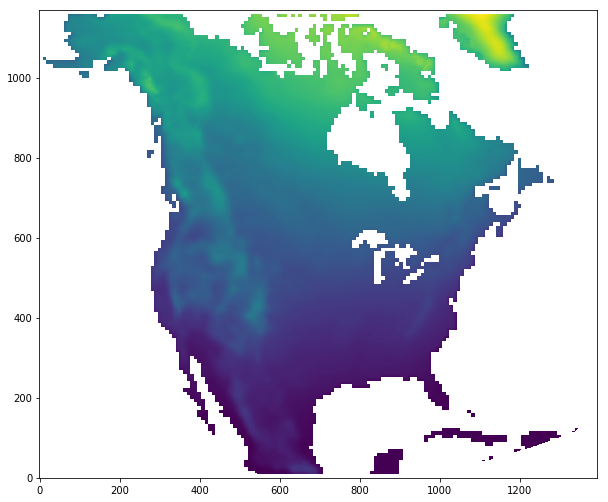

In [245]:
# INTERPOLATE
from scipy.interpolate import LinearNDInterpolator
N = 9
# create a nan mask for ensemble
nanmask = ~np.isnan(mean)
drlon = np.mean(np.diff(ds.rlon))
drlat = np.mean(np.diff(ds.rlat))

nrlon = np.linspace(ds.rlon.min()-drlon, ds.rlon.max()+drlon, ds.rlon.size*N)
nrlat = np.linspace(ds.rlat.min()-drlat, ds.rlat.max()+drlat, ds.rlat.size*N)
# print(nrlon, nrlat)
nrlon2, nrlat2 = np.meshgrid(nrlon, nrlat)

newfield = np.ones(mask.shape)
newfield[:] = np.nan
f = LinearNDInterpolator(np.stack([rlon[nanmask], rlat[nanmask]]).T, mean[nanmask])
newfield[mask] = f(np.stack([nrlon2[mask], nrlat2[mask]]).T).T
plt.figure(figsize=(10, 10))
plt.imshow(newfield, origin='lower')

ds_interp = xr.Dataset(
    {dv: (["rlat", "rlon"], newfield), "lon": nrlon, "lat": nrlat},
    coords={"rlon": ("rlon", nrlon), "rlat": ("rlat", nrlat)},
)

mean = ds_interp[dv].values

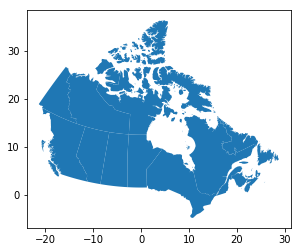

In [246]:
# canada = gpd.read_file('../../climpyrical/tests/data/canada.geojson')
cc = gpd.read_file('../../climpyrical/tests/data/ne_50m_admin_1_states_provinces.shp')
# include Canada, US, Greenland, Mexico, Cuba
cc = cc[
    (cc.iso_a2 == "CA")
]
# exclude Hawaii
cc = cc[cc.name != "Hawaii"]
cc = cc.to_crs({"init": "epsg:4326"})
# extract geometric info of these areas
canada = rotate_shapefile(cc.geometry)

# mean = ds_interp[dv].values

canada.plot()

In [247]:
north_ext = 210
newmean = np.ones((ds_interp[dv].values.shape[0]+north_ext, ds_interp[dv].values.shape[1]))
newmean[0:ds_interp[dv].values.shape[0], 0:ds_interp[dv].values.shape[1]] = mean

drlat = np.mean(np.diff(ds_interp.rlat))
nrlat = np.linspace(ds.rlat.min(), ds.rlat.max()+north_ext*drlat, ds_interp.rlat.size+north_ext)
nrlon = ds_interp.rlon.copy()

dx, dy = np.mean(np.diff(nrlon)), np.mean(np.diff(nrlat))

ds_mean = xr.Dataset(
    {dv: (["rlat", "rlon"], newmean), "lon": nrlon, "lat": nrlat},
    coords={"rlon": ("rlon", nrlon), "rlat": ("rlat", nrlat)},
)

In [248]:
canada.contains(Point(ds_interp.rlon.values[5], ds_interp.rlat.values[5]))

36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
dtype: bool

In [249]:
with xr.open_dataset('canada_mask_rp.nc') as ds:
    print(ds['mask'].shape)
    final_mask_contained = ds['mask'].values

(1380, 1395)


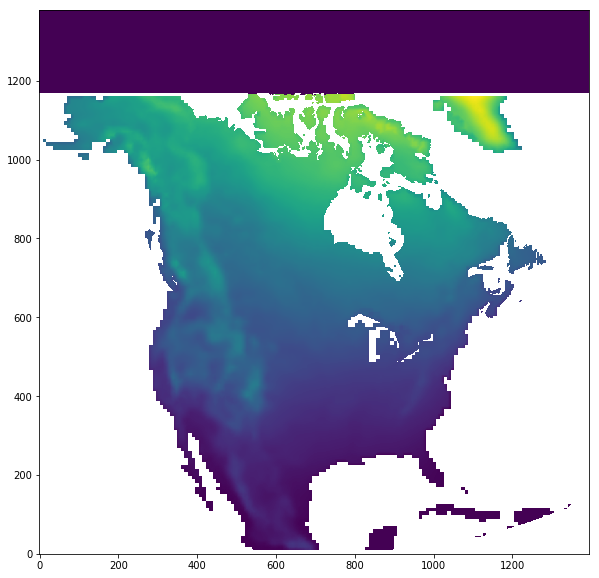

In [250]:
# fine_scale_mask_ds = xr.Dataset(
#     {dv: (["rlat", "rlon"], final_mask_contained), "lon": nrlon, "lat": nrlat},
#     coords={"rlon": ("rlon", nrlon), "rlat": ("rlat", nrlat)},
# )

# fine_scale_mask_ds.to_netcdf('fine_scale_mask.nc')
rlon, rlat = np.meshgrid(ds_mean.rlon, ds_mean.rlat)
model_nan = ~np.isnan(ds_mean[dv].values)
final_mask_c = final_mask_contained == 0.0
this_mask_plz = ~np.logical_or(final_mask_c, model_nan)

newfieldm = ds_mean[dv].values.copy()
f = NearestNDInterpolator(np.stack([rlon[model_nan], rlat[model_nan]]).T, ds_mean[dv].values[model_nan])
newfieldm[this_mask_plz] = f(np.stack([rlon[this_mask_plz], rlat[this_mask_plz]]).T).T

plt.figure(figsize=(10, 10))
plt.imshow(newfieldm, origin='lower')        

In [251]:
ds_mean = xr.Dataset(
    {dv: (["rlat", "rlon"], newfieldm), "lon": nrlon, "lat": nrlat},
    coords={"rlon": ("rlon", nrlon), "rlat": ("rlat", nrlat)},
)

In [252]:
from shapely.geometry import MultiPolygon
pts=[]
for poly in canada:
    if isinstance(poly, MultiPolygon):
        for p in poly:
            pts.extend(p.exterior.coords)
            pts.append([None, None])
    else:
        pts.extend(poly.exterior.coords)
        pts.append([None, None])

X, Y = zip(*pts)

In [253]:
overlaycp = np.ones(final_mask_contained.shape)
fm = final_mask_contained == 1.0
overlaycp[~fm] = np.nan
extent = [nrlon.min(), nrlon.max(), nrlat.min(), nrlat.max()]

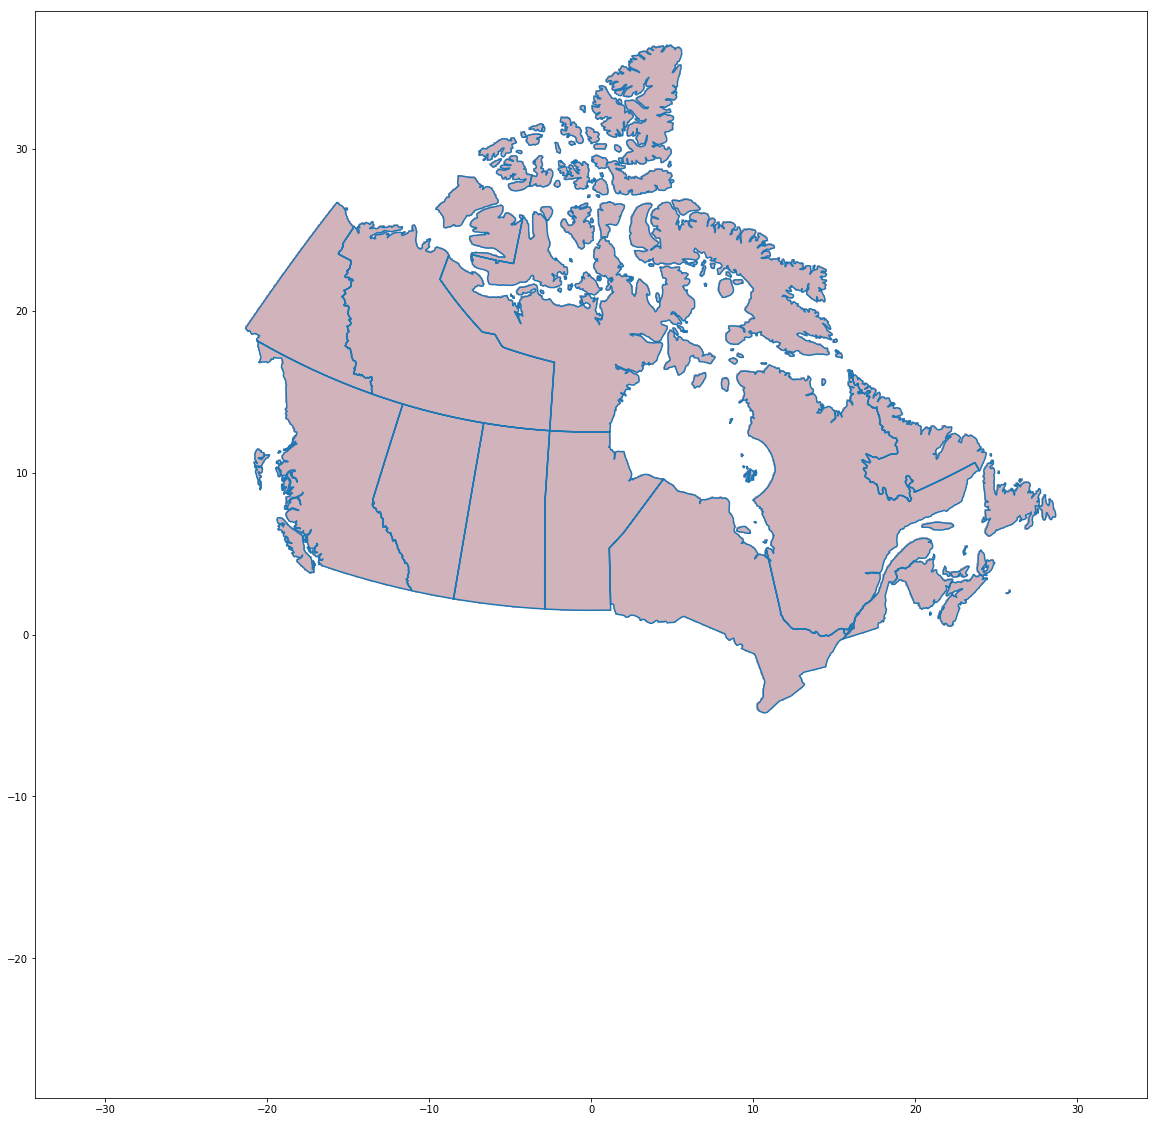

In [254]:
plt.figure(figsize=(20, 20))
plt.plot(X, Y)
plt.imshow(overlaycp, origin='lower', extent = extent, cmap = 'RdBu', alpha=0.3)
plt.savefig('canada', linewidth=0.1)

In [255]:
extent = [nrlon.min(), nrlon.max(), ds_mean.rlat.min(), ds_mean.rlat.max()]

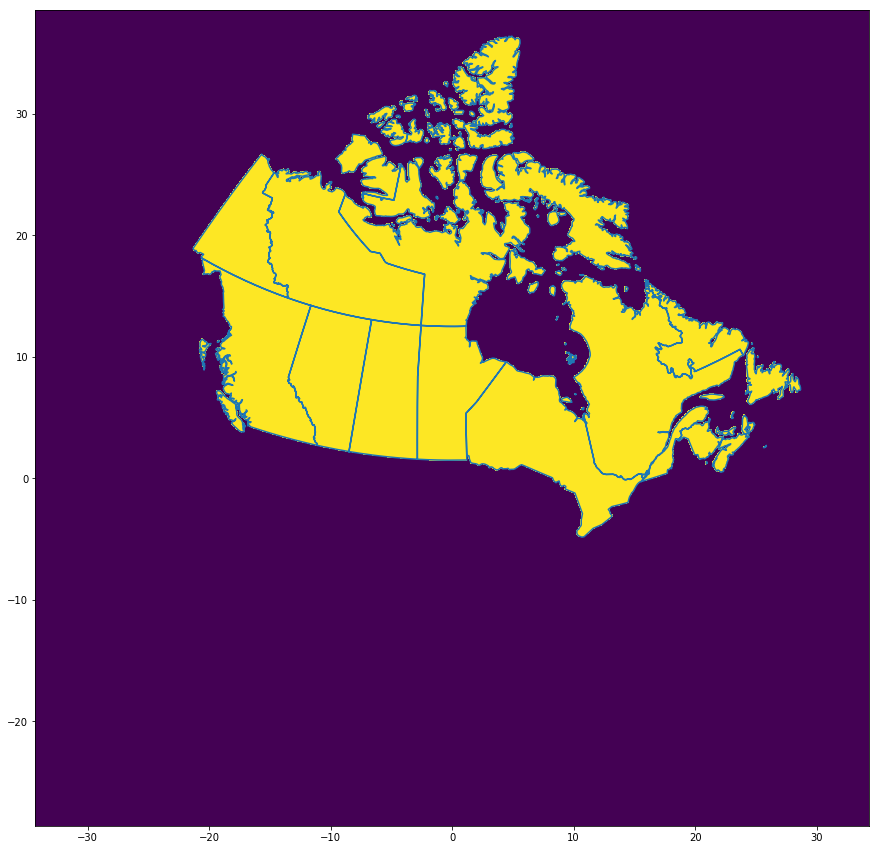

In [256]:
plt.figure(figsize=(15, 15))
plt.plot(X, Y)
plt.imshow(final_mask_contained, origin='lower', extent=extent)

In [257]:
final_mask = np.logical_and(final_mask_contained.copy(), ~np.isnan(ds_mean[dv].values))
mean = ds_mean[dv].values
assert final_mask.shape == mean.shape

In [258]:
rlon, rlat = np.meshgrid(ds_mean.rlon, ds_mean.rlat)
assert rlon.shape == rlat.shape and rlon.shape == final_mask.shape

In [259]:
df_path = '../../climpyrical/tests/data/Interim_hdd_Tmax_Tmin_delivered.csv'
# df_path = '../../climpyrical/tests/data/sl50_short.csv'
df = pd.read_csv(df_path, index_col=None)
station_dv = 'HDD (degC-day)'
# station_dv = 'SL50 (kPa)'

# transform into rotated pole
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)

df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

target = '+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'
df.shape

(1328, 12)

In [260]:
nrc_loc_path = '../../climpyrical/tests/data/NBCC_2020_new_coords.xlsm'
df_nrc_loc = pd.read_excel(nrc_loc_path)[:-1]
id_typo = df_nrc_loc[(df_nrc_loc['2020 Longitude'] > 0) | (df_nrc_loc['2020 Latitude'] < 40)].index
df_nrc_loc.loc[id_typo, '2020 Longitude'] = df_nrc_loc['2015 Long.'].values[id_typo]
df_nrc_loc.loc[id_typo, '2020 Latitude'] = df_nrc_loc['2015 Lat.'].values[id_typo]


In [261]:
rlon_st, rlat_st = transform_coords(df_nrc_loc['2020 Longitude'].values, df_nrc_loc['2020 Latitude'].values)

df_nrc_loc = df_nrc_loc.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

# with open('/home/nannau/trouble_coords_nrc_loc.xlsm') as f:
# df_nrc_loc[(df_nrc_loc.rlon < 50) & (df_nrc_loc.rlat < 40)].assign()

# find nearest grid cells to station locations in rlon and rlat using haversine distance
nearest_gridcell_idx = pairwise_distances_argmin_min( 
    np.deg2rad(
    np.stack([np.array(df_nrc_loc.rlon, dtype=np.float), np.array(df_nrc_loc.rlat, dtype=np.float)]).T
    ),
    np.deg2rad(np.stack([rlon.copy().flatten(), rlat.copy().flatten()]).T), 
    metric='haversine'
)[0]

nearest_gridcell_idx_masked = pairwise_distances_argmin_min( 
    np.deg2rad(
    np.stack([np.array(df_nrc_loc.rlon, dtype=np.float), np.array(df_nrc_loc.rlat, dtype=np.float)]).T
    ),
    np.deg2rad(np.stack([rlon.copy()[final_mask], rlat.copy()[final_mask]]).T), 
    metric='haversine'
)[0]

# create a mesh of indices of rlon and rlat grids for masking 
irlon, irlat = np.meshgrid(range(ds_mean.rlon.size), range(ds_mean.rlat.size))
# combine indices and extract the nearest grid cell index in x and y axis
ix_non_agg, iy_non_agg = np.stack([irlon.flatten(), irlat.flatten()])[:, nearest_gridcell_idx]
ix_non_agg_masked, iy_non_agg_masked = np.stack([irlon[final_mask], irlat[final_mask]])[:, nearest_gridcell_idx_masked]

# where_nan = np.isnan(mean[iy_non_agg, ix_non_agg])
# ix_non_agg[where_nan] = ix_non_agg_masked[where_nan]
# iy_non_agg[where_nan] = iy_non_agg_masked[where_nan]


# add to dataframe
matched_df_nrc = pd.DataFrame({'ilocy': iy_non_agg, 'ilocx': ix_non_agg, 'ilocy_mask': iy_non_agg_masked, 'ilocx_mask': ix_non_agg_masked,'rlat':df_nrc_loc.rlat, 'rlon':df_nrc_loc.rlon, 'lat': df_nrc_loc['2020 Latitude'], 'lon':df_nrc_loc['2020 Longitude'], 'Location':df_nrc_loc.Location})
#

In [262]:
# dup = matched_df_nrc.pivot_table(index = ['ilocy', 'ilocx'], aggfunc ='size') .values > 1

dup = matched_df_nrc.duplicated(['ilocy', 'ilocx']).values
np.sum(dup)

11

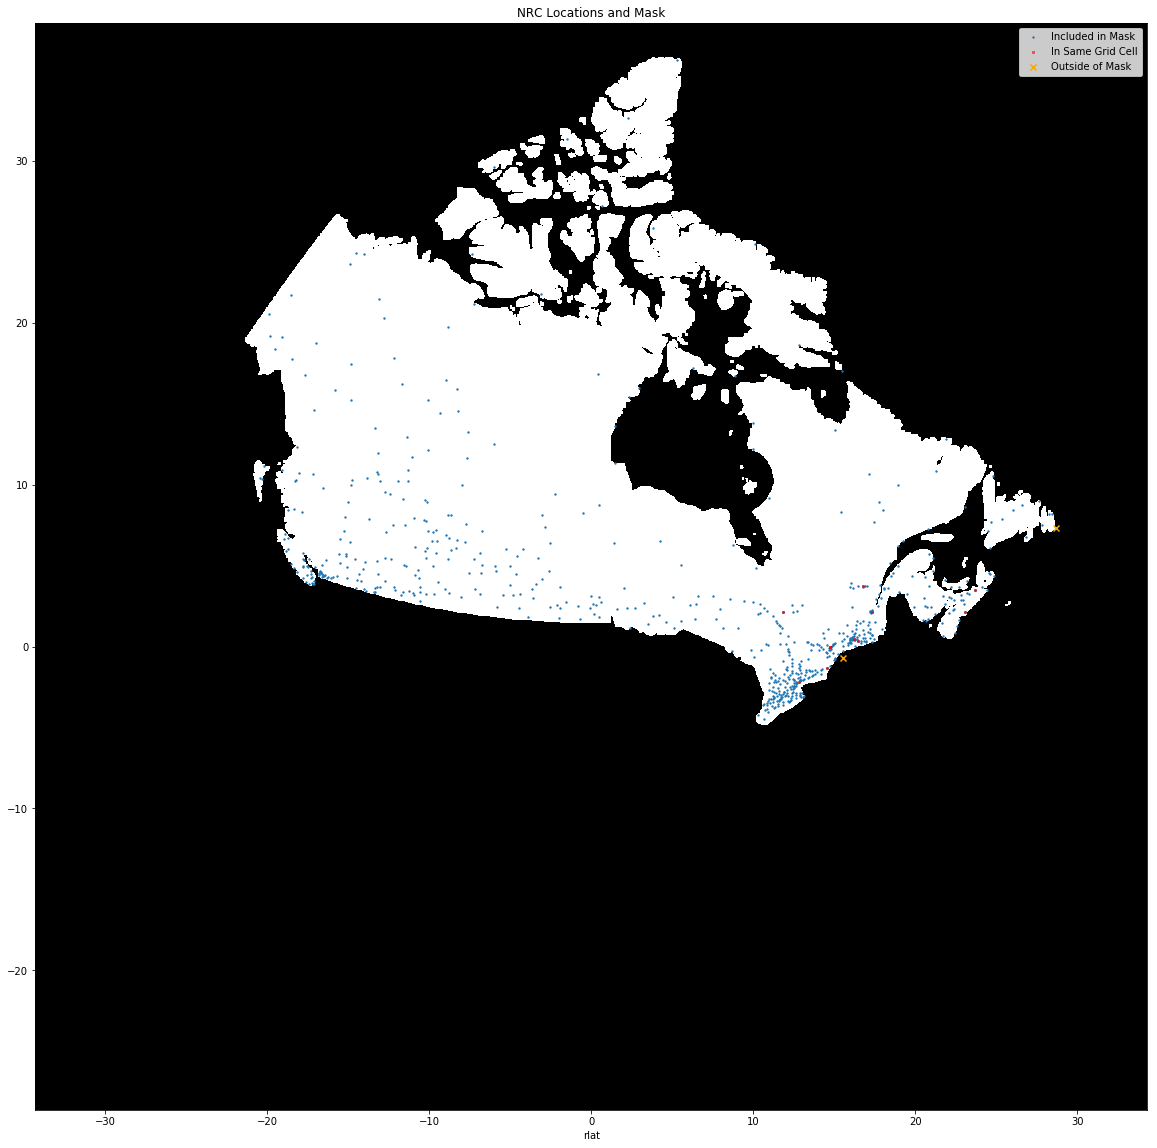

In [263]:
fig, ax = plt.subplots(1, figsize=(20, 20))
# canada.plot(ax = ax, color='red', alpha = 0.3)
ax.imshow(final_mask, origin='lower', extent = extent, cmap='gray')
ax.scatter(matched_df_nrc.rlon, matched_df_nrc.rlat, s = 1.8, label = 'Included in Mask')
ax.scatter(matched_df_nrc.rlon.values[dup], matched_df_nrc.rlat.values[dup], marker='s', alpha = 0.5, s = 5.8, color='red', label = 'In Same Grid Cell')
ax.scatter(matched_df_nrc[(matched_df_nrc.ilocy != matched_df_nrc.ilocy_mask) | (matched_df_nrc.ilocx != matched_df_nrc.ilocx_mask)].rlon,
            matched_df_nrc[(matched_df_nrc.ilocy != matched_df_nrc.ilocy_mask) | (matched_df_nrc.ilocx != matched_df_nrc.ilocx_mask)].rlat,
            marker='x',
            color='orange',
            label = 'Outside of Mask')
ax.set_xlabel('rlon')
ax.set_xlabel('rlat')
ax.set_title('NRC Locations and Mask')
plt.legend()
plt.savefig('nrc_mask_and_loc')

In [264]:
# nanmean = ~np.isnan(ds_mean[dv].values)
# ds_mean_linear = ds_mean[dv].values.copy()
# f = NearestNDInterpolator(np.stack([rlon[nanmean], rlat[nanmean]]).T, ds_mean[dv].values[nanmean])

# # nrlond = np.linspace(ds_mean.rlon.min(), ds_mean.rlon.max(), ds_mean.rlon.size*3)
# # nrlatd = np.linspace(ds_mean.rlat.min(), ds_mean.rlat.max(), ds_mean.rlat.size*3)

# # rlond, rlatd = np.meshgrid(nrlond, nrlatd)

# ds_mean_linear[contained] = f(np.stack([rlon[contained], rlat[contained]]).T)

# ds_mean = xr.Dataset(
#     {dv: (["rlat", "rlon"], ds_mean_linear), "lon": nrlon, "lat": nrlat},
#     coords={"rlon": ("rlon", nrlon), "rlat": ("rlat", nrlat)},
# )

# plt.imshow(ds_mean_linear, origin='lower')

In [265]:
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)
df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

# find nearest grid cells to station locations in rlon and rlat using haversine distance
nearest_gridcell_idx = pairwise_distances_argmin_min( 
    np.deg2rad(
    np.stack([df.rlon, df.rlat]).T
    ),
    np.deg2rad(np.stack([rlon.copy().flatten(), rlat.copy().flatten()]).T), 
    metric='haversine'
)[0]

nearest_gridcell_idx_masked = pairwise_distances_argmin_min( 
    np.deg2rad(
    np.stack([df.rlon, df.rlat]).T
    ),
    np.deg2rad(np.stack([rlon.copy()[final_mask], rlat.copy()[final_mask]]).T), 
    metric='haversine'
)[0]

# create a mesh of indices of rlon and rlat grids for masking 
irlon, irlat = np.meshgrid(range(ds_mean.rlon.size), range(ds_mean.rlat.size))
# combine indices and extract the nearest grid cell index in x and y axis
ix_non_agg, iy_non_agg = np.stack([irlon.flatten(), irlat.flatten()])[:, nearest_gridcell_idx]
ix_non_agg_masked, iy_non_agg_masked = np.stack([irlon[final_mask], irlat[final_mask]])[:, nearest_gridcell_idx_masked]

# where_nan = np.isnan(mean[iy_non_agg, ix_non_agg])
# ix_non_agg[where_nan] = ix_non_agg_masked[where_nan]
# iy_non_agg[where_nan] = iy_non_agg_masked[where_nan]


# add to dataframe
matched_df = pd.DataFrame({'ilocy': iy_non_agg, 'ilocx': ix_non_agg, 'ilocy_mask': iy_non_agg_masked, 'ilocx_mask': ix_non_agg_masked, station_dv: df[station_dv],'rlat':df.rlat, 'rlon':df.rlon, 'lat': df.lat, 'lon':df.lon, 'station_name':df.station_name})
# aggregate stations in same grid cell by taking mean
# matched_df.to_csv('/home/nannau/06172020/dash-dv-explorer/assets/data/snow_stations.csv')
matched_df = matched_df.groupby(['ilocy', 'ilocx'], as_index=False).agg({station_dv: 'mean', 'ilocx_mask': 'mean', 'ilocy_mask': 'mean', 'rlat':'mean', 'rlon':'mean', 'lat': 'mean', 'lon': 'mean', 'station_name': 'first'})#, 'niy': 'min', 'nix': 'min'})


iy = matched_df.ilocy.values
ix = matched_df.ilocx.values
iym, ixm = matched_df.ilocy_mask.values.astype(int), matched_df.ilocx_mask.values.astype(int)

where_nan = np.isnan(ds_mean[dv].values[iy, ix])

station_vals = matched_df[station_dv].values

# comment out for station rlon,rlat
matched_df['rlon'] = rlon[iy, ix]
matched_df['rlat'] = rlat[iy, ix]

matched_df.head()
matched_df.size

12720

In [266]:
matched_df.shape

(1272, 10)

In [267]:
def regionalize(array):
    return array[u:lw, l:r].reshape((lw-u, r-l))
def squareize(array):
    ar = mean.copy()
    ar[final_mask] = array
    ar[~final_mask] = np.nan
    return ar
# mean = ds_mean[dv].values
mean[iy[where_nan], ix[where_nan]] = mean[iym[where_nan], ixm[where_nan]]
oldmean = mean.copy()
meanc = mean.copy()

tol = np.linspace(1, 100, 1000)

print(np.nanmean(station_vals - meanc[iy, ix]))

if np.nanmean(station_vals - meanc[iy, ix]) >= 0:
    rmtols = np.array([np.nanmean(matched_df[station_dv] - (meanc[iy, ix]/t)) for t in tol])
    best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0][0]]

if np.nanmean(matched_df[station_dv] - meanc[iy, ix]) < 0:
    rmtols = np.array([np.nanmean(matched_df[station_dv] + (meanc[iy, ix]/t)) for t in tol])
    best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0][0]]

print(best_tol)
mean = meanc/best_tol
print(best_tol, np.nanmean(matched_df[station_dv] - mean[iy, ix]))

np.nanmean(station_vals - mean[iy, ix])
# print(np.mean(matched_df[station_dv] - meanc[iy, ix]))
# print(np.mean(matched_df[station_dv] - mean[iy, ix]))

128.01140390925403


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# sns.distplot(mean[iy, ix])
# sns.distplot(oldmean[iy, ix])

In [ ]:
newmean = meanc/best_tol
ds_mean = xr.Dataset(
    {dv: (["rlat", "rlon"], newmean), "lon": nrlon, "lat": nrlat},
    coords={"rlon": ("rlon", nrlon), "rlat": ("rlat", nrlat)},
)

In [199]:
assert np.sum(~np.isclose(rlon[iy_non_agg, ix_non_agg], df.rlon, atol=0.6)) < 6

In [200]:
# subset of grid cells closest station locations
# X = np.stack([rlon[iy, ix], rlat[iy, ix], mean[iy, ix]]).T

# full set of locations we wish to predict a value at
# Xf = np.stack([rlon[final_mask], rlat[final_mask], mean[final_mask]]).T

In [201]:
# from sklearn.gaussian_process.kernels import ConstantKernel

# C_0, rho, length_scale = [0.0762, 1.13, 129/2]

In [202]:
# from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, RBF, RBFMOD
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.model_selection import GridSearchCV

# kernel = ConstantKernel(C_0)+ConstantKernel(rho)*RBFMOD(length_scale)
# krig = GaussianProcessRegressor(alpha=5, random_state=0, kernel=kernel)    

# # clf = GridSearchCV(krig, kernel)
# krig.fit(X, station_vals)

# # sorted(krig.cv_results_.keys())

# krigfield = [krig.predict(Xf)]
# # print(krig.kernel)

# # plt.scatter(station_vals, squareize(krigfield[0])[iy, ix])
# # np.sqrt(mean_squared_error(S[iy, ix], station_vals))

In [203]:
ratio = station_vals/mean[iy, ix] #np.var(station_vals, mean[iy, ix])
matched_df = matched_df.assign(ratio=ratio)
def undo(x, mean):
    return x*mean

def undo_rho(x, mean, rho):
    return ((np.ones(x.shape)-rho)+x)*mean

assert np.any(~np.isnan(ratio))

In [204]:
# !cd "/home/nannau/06172020/climpyrical/"; bash r_install.sh
from rpy2.robjects.packages import importr

importr("fields")#, lib_loc="../../r-library/fields/")
# importr("sp", lib_loc="../../r-library/sp/")
# importr("gstat", lib_loc="../../r-library/gstat/")
# importr("geoR", lib_loc="../../r-library/geoR/")

rpy2.robjects.packages.Package as a <module 'fields'>

In [205]:
dfc = matched_df.copy()

In [206]:
from shapely.geometry import Point, Polygon
import climpyrical.spytialProcess as sp

pairs = {
    'north': {
        'x1': -90,
        'x2': -50,
        'y1': 40,
        'y2': 60
    },
    'east': {
        'x1': -140,
        'x2': -100,
        'y1': 55,
        'y2': 80
    },
    'west': {
        'x1': -140,
        'x2': -90,
        'y1': 48,
        'y2': 60
    }
    
}

Z = mean.copy()
Z_py = mean.copy()
Z_py[...] = np.nan
Z[...] = np.nan

# for key in pairs:
key = 'north'
lon1, lon2 = pairs[key]['x1'], pairs[key]['x2']
lat1, lat2 = pairs[key]['y1'], pairs[key]['y2']

dfc = matched_df.copy()

dfc = dfc.assign(ratio = ratio)

region_cond = ((dfc.lon > lon1) & (dfc.lon < lon2) & (dfc.lat > lat1) & (dfc.lat < lat2))
region_cond_df = ((df.lon > lon1) & (df.lon < lon2) & (df.lat > lat1) & (df.lat < lat2))

dfc = dfc[region_cond]

p1 = (dfc.rlon.min(), dfc.rlat.min())
p2 = (dfc.rlon.max(), dfc.rlat.min())
p3 = (dfc.rlon.max(), dfc.rlat.max())
p4 = (dfc.rlon.min(), dfc.rlat.max())

l, rside = find_nearest_index(ds.rlon.values, dfc.rlon.min()), find_nearest_index(ds.rlon.values, dfc.rlon.max())
l, r = find_nearest_index(ds.rlon.values, dfc.rlon.min()), find_nearest_index(ds.rlon.values, dfc.rlon.max())

u, lw = find_nearest_index(ds.rlat.values, dfc.rlat.min()), find_nearest_index(ds.rlat.values, dfc.rlat.max())

final_mask_c = final_mask.copy()
region = final_mask.copy() 
region[...] = False
region[u:lw, l:r] = True


# If True, keep station locations in the mask
final_mask_c[iy, ix] = True
# combine region mask and land mask
region = np.logical_and(final_mask_c, region)
region[dfc.ilocy, dfc.ilocx] = True

latlon = np.stack([dfc.rlon, dfc.rlat])
#     stats = dfc['ratio'].values
stats = dfc[station_dv].values

ylim = lw-u
xlim = r-l

#     okie = OrdinaryKriging(dfc.rlon, dfc.rlat, stats, variogram_model='exponential', exact_values=False, coordinates_type = "geographic")
#     krigfield = okie.execute('points', rlon[region], rlat[region])[0]

#     Z_py[region] = krigfield


In [238]:
mean = ds_mean[dv].values

In [207]:
import matplotlib

from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree

std = StandardScaler() 
N = 10
db = KMeans(n_clusters=N)
# db = DBSCAN(eps=0.2, min_samples=30, metric='haversine')

X = np.stack([matched_df.rlon, matched_df.rlat])
# X
X = std.fit_transform(X.T)
db.fit(X)

db.labels_.shape, matched_df.shape[0]

matched_df = matched_df.assign(label = db.labels_)

# sns.distplot(db.labels_, kde=False)

ccenters = std.inverse_transform(db.cluster_centers_)
xcenter, ycenter = ccenters[:, 0], ccenters[:, 1]

from shapely import geometry

X_distances = np.stack([matched_df.rlon.values, matched_df.rlat.values])
# dfc = matched_df.copy()

Zl = []

In [208]:
latlon = np.stack([dfc.rlon, dfc.rlat]).T
# stats = dfc[station_dv].values
box=5

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=35, metric='euclidean').fit(X_distances.T)
dist, ind = nbrs.kneighbors(X_distances.T)

# tree = KDTree(X_distances.T, leaf_size=2)
# dist, ind = tree.query(X_distances.T, k=35)

In [209]:
from climpyrical.spytialProcess import *

In [210]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [211]:
i_to_drop = []
i_of_drop = []
Zl = []
Zl_r = []
# dfc = matched_df.copy()
# matched_df_region = dfc.copy()
# dfc = matched_df_region.copy()
dfc = matched_df.copy()

from sklearn.neighbors import NearestNeighbors
# nbrs = NearestNeighbors(n_neighbors=35, metric='euclidean').fit(X_distances.T)
# dist, ind = nbrs.kneighbors(X_distances.T)

loglike = []
reml = []
rmse = []
function_name = []

xc, yc = -10, 17.5
# i = 454
i = 0 
# i = 40
print("LON, LAT", df.lon[i], df.lat[i])

per_station_loglike = []

nneighs = np.arange(35, dfc.shape[0])

nug_arr = []
pykrige_variogram_parameters = []

# Three conditions to meet:

# 1.) At least 35 stations in a window [x]
# 2.) Minimum area must be 5x5 grid [x]
# 3.) Windows can not have greater than 50% coverage of any other window [x]

area = np.zeros(mean.shape)
X_distances = np.stack([dfc.rlon.values, dfc.rlat.values])
N = dfc.values.shape[0]

from scipy.spatial import ConvexHull

dA = (np.amax(ds_mean.rlon.values)-np.amin(ds_mean.rlon.values))/ds_mean.rlon.size

Zl = np.empty((N, ds_mean[dv].values.shape[0], ds_mean[dv].values.shape[1]), dtype=np.float32)
Zl[...] = np.nan

# contained = np.array(contained).reshape(mean.shape)

from tqdm import tqdm
import warnings

m, o = 6, 6
nn_val = 40
warnings.simplefilter("ignore")
horizon = 5

dfc = matched_df.copy()

LON, LAT -123.742 48.935


In [212]:
dsold_max = ds.rlat.values.max()

In [213]:
df_north = dfc[dfc.rlat > dsold_max].copy()
df_south = dfc[dfc.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

In [214]:
spacing = np.arange(10, 31, 5)
extent=[ds_mean.rlon.min(), ds_mean.rlon.max(), ds_mean.rlat.min(), ds_mean.rlat.max()]

In [215]:
dfc.rlat.idxmax(axis=0, skipna=True)
dfc = matched_df.copy()

In [217]:
# Zl = np.empty((df_north.shape[0], ds_mean[dv].values.shape[0], ds_mean[dv].values.shape[1]))
# Zl[...] = np.nan
# station_only_final = []
# X_distances = np.stack([dfc.rlon.values, dfc.rlat.values])


# fig, ax = plt.subplots(1, 5, figsize=(40, 20))

# imax = dfc.rlat.idxmax(axis=0, skipna=True)

# for ixm, nn_val in enumerate(spacing):

#     nbrs = NearestNeighbors(n_neighbors=nn_val, metric='euclidean').fit(X_distances.T)
#     dist, ind = nbrs.kneighbors(X_distances.T)
#     temp_df = dfc.iloc[ind[imax]]

#     xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
#     ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

#     latlon = np.stack([temp_df.rlon, temp_df.rlat])
#     stats = temp_df[station_dv]

#     lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
#     l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
#     ylim = u-lw
#     xlim = r-l    

# #     try:
#     z, x, y, cov = sp.fit(latlon, stats, xlim, ylim, extrap=True)

#     final = ds_mean[dv].values.copy()
#     final[:, :] = np.nan
#     final[lw:u, l:r] = z.T

#     nanmask = ~np.isnan(final)

# #     Zl[index, ...] = final
# #     except:
# #         continue
# #     station_only_final.append(np.nanmean(Zl, axis=0))
#     station_only_final.append(final)

#     ax[ixm].imshow(final, origin='lower', extent=extent)
#     ax[ixm].set_title(f'{spacing[ixm]}')
#     ax[ixm].axhline(dsold_max, color='black', ls='--', label='CanRCM4 North Domain')
#     ax[ixm].scatter(dfc.rlon.values[south_index], dfc.rlat.values[south_index], label='stations', marker='x')
#     ax[ixm].scatter(dfc.rlon.values[north_index], dfc.rlat.values[north_index], label='stations above threshold', marker='x')
#     canada.plot(ax=ax[ixm], color='red', zorder=0)
#     ax[ixm].legend()
# plt.savefig('station-only-north-mean-extrap')    
# plt.show()


In [218]:
nbrs = NearestNeighbors(n_neighbors=20, metric='euclidean').fit(X_distances.T)
dist, ind = nbrs.kneighbors(X_distances.T)
temp_df = dfc.iloc[ind[imax]]

xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

latlon = np.stack([temp_df.rlon, temp_df.rlat])
stats = temp_df[station_dv]

lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
ylim = u-lw
xlim = r-l    

#     try:
z, x, y, cov = sp.fit(latlon, stats, xlim, ylim, extrap=True)

final = ds_mean[dv].values.copy()
final[:, :] = np.nan
final[lw:u, l:r] = z.T

nanmask = ~np.isnan(final)

#     Zl[index, ...] = final
#     except:
#         continue
#     station_only_final.append(np.nan
# final = ds_mean[dv].values.copy()
station_final_north = final.copy()

In [219]:
canada

36    POLYGON ((-8.49393 2.20380, -8.70227 2.23928, ...
37    MULTIPOLYGON (((-11.62705 14.22688, -11.74489 ...
38    POLYGON ((4.45477 9.58215, 4.32925 9.41202, 4....
39    MULTIPOLYGON (((22.24337 3.23896, 22.24437 3.2...
40    MULTIPOLYGON (((23.96193 10.12320, 23.83090 10...
41    MULTIPOLYGON (((22.13320 2.99777, 22.15428 3.0...
42    MULTIPOLYGON (((-6.62997 13.05616, -6.94587 13...
43    MULTIPOLYGON (((1.14091 12.51812, 0.89472 12.5...
44    MULTIPOLYGON (((1.20176 1.88394, 1.18820 2.316...
45    POLYGON ((22.19848 3.71753, 22.22123 3.71223, ...
46    MULTIPOLYGON (((19.77909 4.38521, 19.70213 4.3...
47    POLYGON ((-8.49393 2.20380, -8.43663 2.54390, ...
48    MULTIPOLYGON (((-13.49519 14.83934, -13.95653 ...
Name: geometry, dtype: geometry

In [220]:
dsold_max  = ds_mean.rlat.values[-north_ext]
dsold_max

28.34267894465885

In [221]:
# for polygon in canada.geometry:
#     print(polygon.area)

def to_polygons(geometries):
    for geometry in geometries:
        if isinstance(geometry, Polygon):
            yield geometry
        else:
            yield from geometry

canada_polygons = MultiPolygon(to_polygons(canada))
polygon_above_north_idx = np.array([p.centroid.y + 1 >= dsold_max for p in canada]) 
M2 = gpd.GeoSeries(MultiPolygon([P for P in canada_polygons if P.centroid.y + 1 >= dsold_max]))

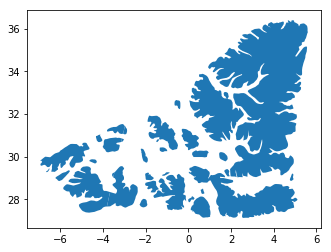

In [222]:
M2.plot()

In [223]:
rlat_above_thresh = ds_mean.rlat >= dsold_max - 1.

# xx, yy = flatten_coords(ds_mean.rlon, ds_mean.rlat.values[rlat_above_thresh])
rlon, rlat = np.meshgrid(ds_mean.rlon, ds_mean.rlat)

# gen_raster_mask_from_vector(ds_mean.rlon.values, ds_mean.rlat.values[rlat_above_thresh], gpd.GeoSeries(canada_polygons[polygon_above_north_idx]))
# grid = np.meshgrid(x, y)[0]
# for i, rlon in enumerate(ds_mean.rlon):
#     for j, rlat in enumerate(ds_mean.rlat.values[rlat_above_thresh]):
#         pt = Point(rlon, rlat)
#         grid[j, i] = p.contains(pt)
        
from shapely.geometry.multipolygon import MultiPolygon

northern_mask = np.ones(ds_mean[dv].shape) == 2.0
northern_mask[-(north_ext+50):, :] = gen_raster_mask_from_vector(
    ds_mean.rlon.values, 
    ds_mean.rlat.values[-(north_ext+50):], 
    M2
)

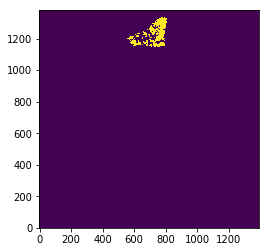

In [224]:
plt.imshow(northern_mask, origin='lower')

In [225]:
pts = []
for poly in canada:
    if isinstance(poly, MultiPolygon):
        for p in poly:
            pts.extend(p.exterior.coords)
            pts.append([None, None])
    else:
        pts.extend(poly.exterior.coords)
        pts.append([None, None])

X, Y = zip(*pts)

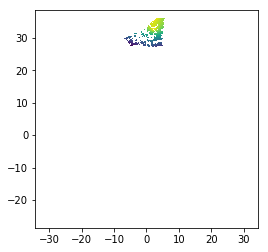

In [226]:
station_final_north[~northern_mask] = np.nan
contained = final_mask_contained.copy()
plt.imshow(station_final_north, origin='lower', extent=[ds_mean.rlon.min(), ds_mean.rlon.max(), ds_mean.rlat.min(), ds_mean.rlat.max()])

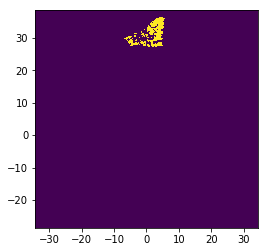

In [227]:
plt.imshow(np.logical_and(northern_mask, final_mask_contained), origin='lower', extent=[ds_mean.rlon.min(), ds_mean.rlon.max(), ds_mean.rlat.min(), ds_mean.rlat.max()])

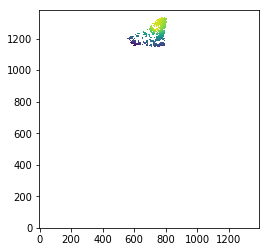

In [228]:
st_nan = ~np.isnan(station_final_north)
f = NearestNDInterpolator(np.stack([rlon[st_nan], rlat[st_nan]]).T, station_final_north[st_nan])
station_final_north[np.logical_and(northern_mask, contained)] = f(np.stack([rlon[np.logical_and(northern_mask, contained)], rlat[np.logical_and(northern_mask, contained)]]).T)

plt.imshow(station_final_north, origin='lower')

In [242]:
ds_mean[dv].values
np.nanmax(station_final_north), np.nanmax(mean)

(13327.88494294702, -0.04284560586140565)

In [229]:
frac_cov = 1
Zl = np.empty((N, ds_mean[dv].values.shape[0], ds_mean[dv].values.shape[1]), dtype=np.float16)
Zl[...] = np.nan

tracker = np.zeros(ds_mean[dv].values.shape)

X_distances = np.stack([dfc.rlon.values[south_index], dfc.rlat.values[south_index]])

for i in tqdm(south_index):
    nn = 30

    nbrs = NearestNeighbors(n_neighbors=nn, metric='euclidean').fit(X_distances.T)
    dist, ind = nbrs.kneighbors(X_distances.T)
    temp_df = dfc.iloc[ind[i]]

    xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
    ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

    latlon = np.stack([temp_df.rlon, temp_df.rlat])
    stats = temp_df.ratio

    lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
    l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
    ylim = u-lw
    xlim = r-l

    hull = ConvexHull(points=latlon.T)
    stats = temp_df.ratio

    while hull.area < (dA**2)*(3*5)**2:
        nn+=1
        nbrs = NearestNeighbors(n_neighbors=nn, metric='euclidean').fit(X_distances.T)
        dist, ind = nbrs.kneighbors(X_distances.T)

        temp_df = dfc.iloc[ind[i]]

        xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
        ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

        latlon = np.stack([temp_df.rlon, temp_df.rlat])

        hull = ConvexHull(points=latlon.T)
        stats = temp_df.ratio

        lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
        l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
        ylim = u-lw
        xlim = r-l

    try:
        z, x, y, cov = sp.fit(latlon, stats, xlim, ylim, extrap=False)

        final = ds_mean[dv].values.copy()
        final[:, :] = np.nan
        final[lw:u, l:r] = z.T

        nanmask = ~np.isnan(final)
        area[nanmask] += 1.0
        
        tracker[nanmask] += 1.0

        # field already has kriged values in it? If so, where, True?
        n_tot = np.sum(nanmask)
        n_sum = np.sum(
                      area[nanmask] > 1.0
                )

        if float(n_sum)/n_tot >= frac_cov:
            area[lw:u, l:r] -= 1.0
        else:
#             Zl = np.nansum(np.stack([Zl, final]), axis=0)
            Zl[i, ...] = final

    except:
        continue


  6%|▌         | 78/1272 [00:40<22:24,  1.13s/it]R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 3: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/

In [230]:
cpc = contained == 1.0

In [231]:
# plt.imshow(np.divide(Zl, tracker), origin='lower')
# Zl.shape, tracker.shape
# ratio = np.divide(Zl, tracker)

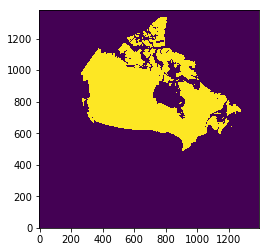

In [232]:
plt.imshow(cpc, origin='lower')

In [233]:
# plt.imshow(np.nanmean(Zl, axis=0), origin='lower')
FINAL_THING = np.zeros(ds_mean[dv].shape)
FINAL_THING[:] = np.nan
FINAL_THING[cpc] = np.nanmean(Zl[:, cpc], axis=0)

ratio = FINAL_THING.copy()
# import dask.array as da

# x = da.from_array(Zl, chunks=(100, Zl.shape[1], Zl.shape[2]))
# ratio = da.nanmean(Zl, axis=0).compute()

In [234]:
# FINAL_THING = np.zeros(ds_mean[dv].shape)
# FINAL_THING[:] = np.nan
# FINAL_THING[cpc] = ratio

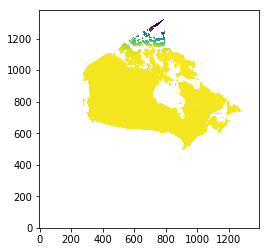

In [235]:
plt.imshow(ratio, origin='lower')
# ratio = FINAL_THING.copy()

In [143]:
# ratio = np.nanmean(Zll, axis=0)

In [144]:
ratio.shape, cpc.shape
# plt.imshow(ratio)

((1380, 1395), (1380, 1395))

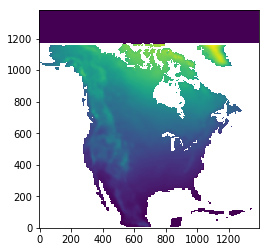

In [145]:
plt.imshow(ds_mean[dv].values, origin='lower')

In [146]:
# ratio = np.nanmean(Zl, axis = 0)

r_nan = ~np.isnan(ratio)
f = NearestNDInterpolator(np.stack([rlon[r_nan], rlat[r_nan]]).T, ratio[r_nan])
ratio[cpc] = f(np.stack([rlon[cpc], rlat[cpc]]).T)

ratio_final = ratio*ds_mean[dv].values
# final_final = np.nansum(station_only_final, ratio_final)
ratio_final[northern_mask] = np.array(station_final_north)[northern_mask]
ratio_final[~cpc] = np.nan
fig, ax = plt.subplots(1, 2, figsize=(35, 35))
col1 = ax[0].imshow(ratio_final, origin='lower', extent=extent)#, cmap = plt.cm.get_cmap("viridis", 15))
ax[0].set_title('Ratio Reconstruction Patched')
canada.plot(ax=ax[0], zorder=0, color='red')
ax[0].plot(X, Y, color='black')
plt.colorbar(col1, ax = ax[0], fraction=0.058, pad=0.05)

col2 = ax[1].imshow(np.absolute(ratio_final-ds_mean[dv].values), origin='lower', vmin=0, vmax=3, extent=extent)#, cmap=plt.cm.get_cmap("viridis", 10))
plt.colorbar(col2, ax = ax[1], fraction=0.058, pad=0.05)
ax[1].set_title('|Reconstruction - Mean|')
canada.plot(ax=ax[1], zorder=0, color='red')
ax[1].plot(X, Y, color='black')
plt.savefig('non-interp-full-reconstruction-patched.pdf')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [378]:
print("Reconstruction (max, min, mean, median)", np.nanmax(ratio_final), np.nanmin(ratio_final), np.nanmean(ratio_final), np.nanmedian(ratio_final))
print("Model mean (max, min, mean, median)", np.nanmax(oldmean[cpc]), np.nanmin(oldmean[cpc]), np.nanmean(oldmean[cpc]), np.nanmedian(oldmean[cpc]))

Reconstruction (max, min, mean, median) 13270.920712294634 2614.5684996531427 8072.937776167267 7720.197589840816
Model mean (max, min, mean, median) 14007.33916234331 1.0 7387.836427557393 7168.531444614376


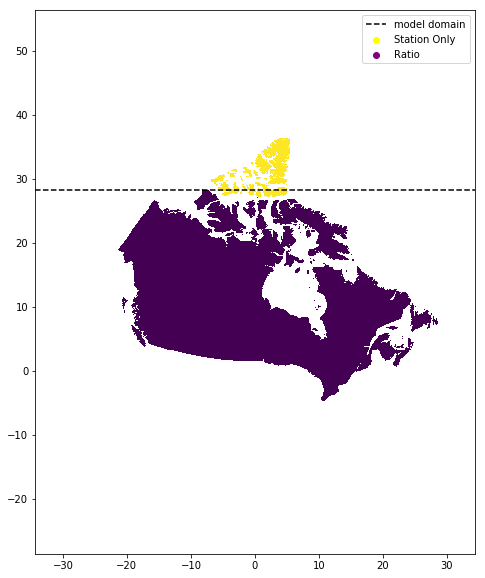

In [138]:
zro = np.zeros(ds_mean[dv].shape)
zro[:] = np.nan
zro[northern_mask] = 1.0
zro[cpc^northern_mask] = 0.

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(zro, origin='lower', extent=extent)
plt.scatter(0., 10., label='Station Only', color='yellow', zorder=0)
plt.scatter(0., 10., label='Ratio', color='purple', zorder=0)
plt.gca().axhline(dsold_max, ls='--', color='black', label='model domain')
plt.legend()
plt.savefig('regimes')
